#Method 1

In [88]:
from imutils.video import VideoStream
import imutils
import cv2
import numpy as np
import copy
from matplotlib import pyplot as plt
import pandas as pd

In [89]:
def init_data(point,t):
    data = {}
    point.append(t)
    data["points"] = [point]
    data["last_slope"] = None
    return data

def same_point(point1, point2):
    if point1[0] == point2[0] and point1[1] == point2[1]:
        return True
    if point1[0] == point2[0] and point1[1] != point2[1]:
        return None  # corresponds to infinite slope
    else:
        return False
    
def average_point(point1, point2):
    return [(point1[0] + point2[0])/2, (point1[1] + point2[1])/2, point2[2]] 

In [90]:
def get_slope(point1, point2):
    return (point1[1]-point2[1])/(point1[0]-point2[0])

def proximity(point1, point2, R=50):
    if (point1[0] - point2[0])**2 + (point1[1] - point2[1])**2 <= R**2:
        return True
    else:
        return False
    
def time_continuity(time1, point):
    time2 = point[-1]
    if time1 == time2:
        return None
    if time1 - time2 <= 2 and time1 - time2 > 0:
        return True
    else:
        return False
    
def add_time(point, t):
    if len(point) == 2:
        point.append(t)

In [91]:
def update_line(point, data,t):
    """
    Returns the updated line (data) with all the points and last slope. If the point does not lie within this 
    "band" then returns the unchanged line (data)
    """
    list_of_previous_points = data["points"]
    last_slope = data["last_slope"]
    last_point = list_of_previous_points[-1]
    initial_point = list_of_previous_points[0]

    if proximity(point, last_point) is True:  # point is in close proximity
        if len(list_of_previous_points) >= 2:
            if same_point(point, last_point) is False:
                    if time_continuity(t, last_point) is None:
                        list_of_previous_points[-1] = average_point(point, last_point)  # honestly, I should check the slopes here as well no?
                        #data["points"] = list_of_previous_points
                        
                    if time_continuity(t, last_point) is True:
                        slope_to_test = get_slope(point, last_point)
                        if same_point(point, initial_point) is False:
                            slope_init = get_slope(point, initial_point)
                            if check_slope(slope_init, last_slope, slope_to_test) is True:
                                print("passed constraints")
                                add_time(point,t)
                                list_of_previous_points.append(point)
                                # update dict
                                #data["points"] = list_of_previous_points
                                data["last_slope"] = slope_to_test

            if same_point(point, last_point) is True:
                add_time(point,t)
                list_of_previous_points.append(point)
                #data["points"] = list_of_previous_points

        if len(list_of_previous_points) == 1:
            if same_point(point, initial_point) is False:
                if time_continuity(t,initial_point) is True:
                    slope = (point[1]-initial_point[1])/(point[0]-initial_point[0])
                    # update dict
                    data["last_slope"] = slope
                    add_time(point,t)
                    list_of_previous_points.append(point)
                if time_continuity(t, initial_point) is None:
                    list_of_previous_points[0] = average_point(point,initial_point)

            if same_point(point, initial_point) is True:
                if time_continuity(t,initial_point) is True:
                    add_time(point,t)
                    list_of_previous_points.append(point)       
            
            #data["points"] = list_of_previous_points
    
    return data
            
        
def check_slope(slope1, slope2, slope3, slope_error=2):
    """
    checks if slope3 is similar to slopes 2 and 3.   
    """
    if slope2 is None:
        if abs(slope1 - slope3) <= slope_error:
            return True
    if slope2 is not None:
        if abs(slope1 - slope3) <= slope_error and abs(slope2 - slope3) <= slope_error:
            return True
    else:
        return False

In [71]:
test_data = {}
test_data["points"] = [[990,537,0]]
test_data["last_slope"] = None
point =[989,537]
update_line(point,test_data,0)
test_data

{'points': [[989.5, 537.0, 0]], 'last_slope': None}

In [92]:
def check_for_lines(datas,point, t):
    if bool(datas) is False:  # no data points yet
        data = init_data(point,t)
        datas.append(data)
    else:
        count = 0  # used to keep in memory the amount of times a point was part of a line
        for i in range(len(datas)):
            line = copy.deepcopy(datas[i])
            new_line = datas[i]
            update_line(point,new_line,t)  
            if line != new_line:
                count += 1
                
        if count == 0: # the point didn't correspond to any existing line
            data = init_data(point,t)
            datas.append(data)  # create a new line

    return datas

In [112]:
def to_unit_vector(point, width=1080, height=1980 , AOV=np.radians(39.23)):
    """
    y points through the screen and x points right (CCW motion). Point is in cols, rows.
    Output corresponds to rows, cols.
    """
    distance_to_screen = (width**2+height**2)**0.5/(2*np.tan(AOV))
    vector = np.array((point[0]-height/2, distance_to_screen, width/2-point[1], point[2]))
    #print("vector in px", vector)
    vector[:-1] = vector[:-1]/np.linalg.norm(vector[:-1])
    return vector

to_unit_vector([1011,433,0])

array([0.01515684, 0.99689827, 0.0772277 , 0.        ])

In [19]:
np.degrees(0.6847)

39.230420232607464

In [94]:
video_location = 'Earth_ball.avi'
vs = cv2.VideoCapture(video_location)

In [95]:
# initialize the first frame in the video stream
avg = None
# initialise data on debris lines
datas = []

In [96]:
#main body
accumulated_thresh = np.zeros((1080,1920))
t=0
while True:
    frame = vs.read()
    frame = frame[1]
    text = "unoccupied"
    
    # if the frame could not be grabbed, then we have reached the end
    # of the video
    if frame is None:
        break
    
    # resize the frame, convert it to grayscale, and blur it
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # if the first frame is None, initialize it
    if avg is None:
        avg = gray.copy().astype("float")
        continue

    # compute the absolute difference between the current frame and
    # first frame
    cv2.accumulateWeighted(gray, avg, 0.5)
    frameDelta = cv2.absdiff(gray, cv2.convertScaleAbs(avg))
    thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]

    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_TREE,
    	cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # save the contours into an accumulated thresh image
    accumulated_thresh = cv2.accumulate(thresh, accumulated_thresh)

	# loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 200:
		# compute the bounding box for the contour, draw it on the frame,
		# and update the text
            """
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            """
            ellipse = cv2.fitEllipse(c)
            cv2.ellipse(frame,ellipse,(0,255,0),2)
            text = "Occupied"
            # get the location of the centroid
            M = cv2.moments(c)
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            print("-------------------------------")
            print([cx,cy], t)  # cols, rows 
            datas = check_for_lines(datas, [cx,cy],t)  

    
    # draw the text and timestamp on the frame
    #cv2.putText(frame, "Room Status: {}".format(text), (10, 20),
    #cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    #cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
    #(10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)

	# show the frame and record if the user presses a key
    """
    cv2.imshow("Satellite Feed", frame)
    cv2.imshow("accumulated", accumulated_thresh)
    cv2.imshow("Thresh", thresh)
    cv2.imshow("Frame Delta", frameDelta)
    cv2.waitKey(0)
    """
    t+=1
    
cv2.destroyAllWindows()

-------------------------------
[990, 537] 0
-------------------------------
[989, 537] 0
-------------------------------
[991, 532] 1
-------------------------------
[990, 533] 1
-------------------------------
[993, 526] 2
passed constraints
-------------------------------
[991, 526] 2
-------------------------------
[994, 519] 3
passed constraints
-------------------------------
[994, 519] 3
-------------------------------
[995, 512] 4
-------------------------------
[996, 512] 4
passed constraints
-------------------------------
[997, 505] 5
-------------------------------
[998, 505] 5
passed constraints
-------------------------------
[998, 497] 6
-------------------------------
[999, 497] 6
passed constraints
-------------------------------
[999, 490] 7
-------------------------------
[1001, 491] 7
passed constraints
-------------------------------
[1000, 482] 8
-------------------------------
[1002, 484] 8
passed constraints
-------------------------------
[1002, 475] 9
--------

Data analysis

In [97]:
for dict in datas:
    for points in dict["points"]:
        for point in points:
            if len(points) != 3:
                print("Wtf", point)

In [103]:
datas_copy = copy.deepcopy(datas)
datas_new = copy.deepcopy(datas)

In [104]:
for dict in datas_copy:
    if len(dict["points"]) <= 15:
        #print(len(dict["points"]))
        #print("-----------------")
        #print(dict)
        datas_new.remove(dict)

In [80]:
xs=[]
ys=[]
for point in datas_new[0]["points"]:
    xs.append(point[0])
    ys.append(point[1])

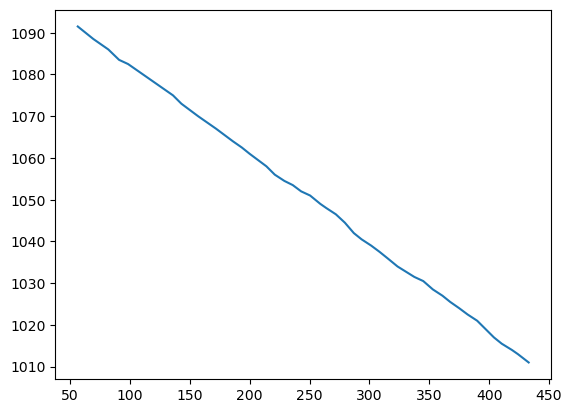

In [81]:
plt.plot(ys,xs)

In [105]:
set_of_meas = []
for dict1 in datas_new:
    line = []
    for point in dict1["points"]:
        new_point = to_unit_vector(point)
        line.append(new_point)
    set_of_meas.append(line)

In [106]:
df = pd.DataFrame(set_of_meas)
df.to_csv('data/measurments.csv', index=False)

Debug

In [109]:
%store -r new_corners

In [113]:
line = []
for point in new_corners:
    new_point = to_unit_vector(point)
    line.append(new_point)
line


[array([0., 1., 0., 0.]),
 array([0.00144798, 0.99998611, 0.00506793, 1.        ]),
 array([0.00289584, 0.99994444, 0.01013544, 2.        ]),
 array([0.00361956, 0.99987789, 0.01520214, 3.        ]),
 array([0.00506682, 0.99976682, 0.0209911 , 4.        ]),
 array([0.00578994, 0.99964375, 0.02605471, 5.        ]),
 array([0.0072363 , 0.99948958, 0.03111611, 6.        ]),
 array([0.00795832, 0.99928736, 0.03689768, 7.        ]),
 array([0.0094033 , 0.99907533, 0.04195317, 8.        ]),
 array([0.01012427, 0.99884332, 0.04700556, 9.        ]),
 array([ 0.01156752,  0.99857728,  0.05205383, 10.        ]),
 array([ 0.01300909,  0.99824237,  0.05781819, 11.        ]),
 array([ 0.0137275 ,  0.9979281 ,  0.06285749, 12.        ]),
 array([ 0.01516717,  0.99757744,  0.06789112, 13.        ]),
 array([ 0.01588274,  0.99715854,  0.07363815, 14.        ]),
 array([ 0.01731954,  0.99675107,  0.0786596 , 15.        ]),
 array([ 0.01803357,  0.99632984,  0.08367575, 16.        ]),
 array([ 0.0194672

In [114]:
%store line

Stored 'line' (list)


#Method 2

In [9]:
# KNN
backSub = cv2.createBackgroundSubtractorKNN()

In [10]:
# MOG2
backSub = cv2.createBackgroundSubtractorMOG2()

In [11]:
while True:
    ret, frame = vs.read()
    if frame is None:
        break

    fgMask = backSub.apply(frame)

    thresh = cv2.dilate(fgMask, None, iterations=2)  # makes bright regions grow
    cnts = cv2.findContours(fgMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 200:
            # compute the bounding box for the contour, draw it on the frame
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = "Occupied"

    cv2.rectangle(frame, (10, 2), (100, 20), (255, 255, 255), 1)
   
    cv2.imshow('Frame', frame)
    cv2.imshow('Thresh', thresh)
    cv2.imshow('FG Mask', fgMask)

    cv2.waitKey(0)
    
cv2.destroyAllWindows()